In [6]:
from preprocessing import load_dataset
%matplotlib inline
import numpy as np
from matplotlib import pyplot as plt
import cv2
import seaborn as sns
from mpl_toolkits.axes_grid import ImageGrid
from sklearn.model_selection import train_test_split
from skimage import *

<ipython-input-6-648c5c6ba92e>:7: MatplotlibDeprecationWarning: 
The mpl_toolkits.axes_grid module was deprecated in Matplotlib 2.1 and will be removed two minor releases later. Use mpl_toolkits.axes_grid1 and mpl_toolkits.axisartist, which provide the same functionality instead.
  from mpl_toolkits.axes_grid import ImageGrid


In [7]:
DATA_PATH = "../dataset_mri/lgg-mri-segmentation/kaggle_3m/"
IMG_SIZE=224
dataset=load_dataset(DATA_PATH)
dataset.head()

,patient_id,image_path,image_data,mask_path,mask_data,tumor
0,TCGA_CS_4941_19960909_1,../dataset_mri/lgg-mri-segmentation/kaggle_3m/...,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",../dataset_mri/lgg-mri-segmentation/kaggle_3m/...,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",0
1,TCGA_CS_4941_19960909_10,../dataset_mri/lgg-mri-segmentation/kaggle_3m/...,"[[2, 3, 3, 2, 2, 2, 1, 2, 2, 1, 1, 1, 2, 3, 4,...",../dataset_mri/lgg-mri-segmentation/kaggle_3m/...,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",0
2,TCGA_CS_4941_19960909_11,../dataset_mri/lgg-mri-segmentation/kaggle_3m/...,"[[1, 1, 2, 2, 3, 2, 4, 3, 3, 3, 2, 2, 2, 3, 5,...",../dataset_mri/lgg-mri-segmentation/kaggle_3m/...,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",1
3,TCGA_CS_4941_19960909_12,../dataset_mri/lgg-mri-segmentation/kaggle_3m/...,"[[4, 2, 2, 4, 3, 2, 2, 2, 3, 4, 4, 3, 2, 2, 3,...",../dataset_mri/lgg-mri-segmentation/kaggle_3m/...,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",1
4,TCGA_CS_4941_19960909_13,../dataset_mri/lgg-mri-segmentation/kaggle_3m/...,"[[3, 1, 2, 3, 2, 3, 4, 5, 6, 5, 3, 2, 2, 2, 4,...",../dataset_mri/lgg-mri-segmentation/kaggle_3m/...,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",1


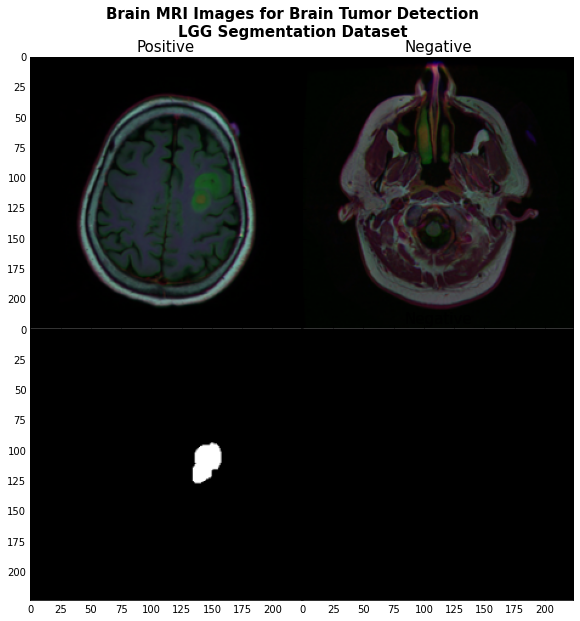

In [9]:
# Data
sample_yes_df = dataset[dataset["tumor"] == 1].sample(2)
sample_no_df = dataset[dataset["tumor"] == 0].sample(2)
image_yes = sample_yes_df.image_path.values
image_no= sample_no_df.image_path.values
mask_yes = sample_yes_df.mask_path.values
mask_no= sample_no_df.mask_path.values

sample_imgs = []
for i, (yes, no,yes_mask,no_mask) in enumerate(zip(image_yes, image_no, mask_yes, mask_no)):
    yes = cv2.resize(cv2.imread(yes), (IMG_SIZE, IMG_SIZE))
    no = cv2.resize(cv2.imread(no), (IMG_SIZE, IMG_SIZE))
    yes_mask= cv2.resize(cv2.imread(yes_mask), (IMG_SIZE, IMG_SIZE))
    no_mask= cv2.resize(cv2.imread(no_mask), (IMG_SIZE, IMG_SIZE))

# Plot
fig = plt.figure(figsize=(10., 10.))
grid = ImageGrid(fig, 111, nrows_ncols=(2, 2))

#MR Images
grid[0].imshow(yes)
grid[0].set_title("Positive", fontsize=15)
grid[0].axis("off")
grid[1].imshow(no)
grid[1].set_title("Negative", fontsize=15)
grid[1].axis("off")
#Mask corresponding
grid[2].imshow(yes_mask)
grid[2].set_title("Positive", fontsize=15)
grid[2].axis("off")
grid[3].imshow(no_mask)
grid[3].set_title("Negative", fontsize=15)
grid[3].axis("off")
# annotations
plt.suptitle("Brain MRI Images for Brain Tumor Detection\nLGG Segmentation Dataset", y=.95, fontsize=15, weight="bold")

# save and show
plt.savefig("dataset.png", bbox_inches='tight', pad_inches=0.2, transparent=True)
plt.show()

In [17]:
img = cv2.imread("../dataset_mri/lgg-mri-segmentation/kaggle_3m/TCGA_CS_4941_19960909/TCGA_CS_4941_19960909_15.tif")
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

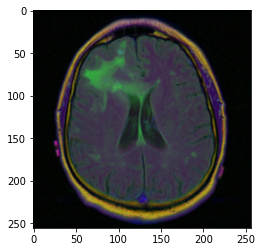

In [42]:
plt.imshow(img)

In [44]:
def color_features(img):
    """ Represents a pixel by its color.
    Args:
        img - array of shape (H, W, C)
    Returns:
        features - array of (H * W, C)
    """
    H, W, C = img.shape
    print(H, W, C)
    color = cv2.normalize(img, None, alpha=0, beta=1, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_32F)
    features = np.zeros((H*W, C))

    features = color.reshape(H*W, C)

    return features


In [45]:
features = color_features(img)
features.dtype

256 256 3


dtype('float32')

In [43]:
def kmeans_fast(features, k, num_iters=100):
    """ Use kmeans algorithm to group features into k clusters.
    This function makes use of numpy functions and broadcasting to speed up the
    first part(cluster assignment) of kmeans algorithm.
    Hints
    - You may find np.repeat and np.argmin useful
    Args:
        features - Array of N features vectors. Each row represents a feature
            vector.
        k - Number of clusters to form.
        num_iters - Maximum number of iterations the algorithm will run.
    Returns:
        assignments - Array representing cluster assignment of each point.
            (e.g. i-th point is assigned to cluster assignments[i])
    """

    N, D = features.shape

    assert N >= k, 'Number of clusters cannot be greater than number of points'

    # Randomly initalize cluster centers
    idxs = np.random.choice(N, size=k, replace=False)
    centers = features[idxs]
    assignments = np.zeros(N)

    for n in range(num_iters):
        f_tmp = np.tile(features, (k, 1))
        c_tmp = np.repeat(centers, N, axis=0)
        assignments = np.argmin(np.sum((f_tmp - c_tmp)**2, axis=1).reshape(k, N), axis=0)
        tmp = centers.copy()
        for j in range(k):
            centers[j] = np.mean(features[assignments == j], axis=0)
        if np.allclose(tmp, centers):
            break

    return assignments


256 256 3


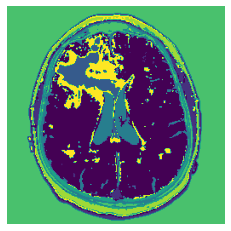

In [46]:
np.random.seed(0)
features = color_features(img)
## on ne considere que ce vecteur caractéristique pour faire le k-means 
H, W, C = img.shape

# Sanity checks
assert features.shape == (H * W, C),\
    "Incorrect shape! Check your implementation."

assert features.dtype == np.float32,\
    "dtype of color_features should be float."

assignments = kmeans_fast(features, 8)
segments = assignments.reshape((H, W))

# Display segmentation
plt.imshow(segments, cmap='viridis')
plt.axis('off')
plt.show()

In [40]:
def visualize_mean_color_image(img, segments):

    img = img_as_float(img)
    k = np.max(segments) + 1
    mean_color_img = np.zeros(img.shape)

    for i in range(k):
        mean_color = np.mean(img[segments == i], axis=0)
        mean_color_img[segments == i] = mean_color

    plt.imshow(mean_color_img)
    plt.axis('off')
    plt.show()

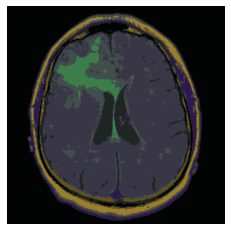

In [41]:
visualize_mean_color_image(img, segments)

In [47]:
def color_position_features(img):
    """ Represents a pixel by its color and position.
    Combine pixel's RGB value and xy coordinates into a feature vector.
    i.e. for a pixel of color (r, g, b) located at position (x, y) in the
    image. its feature vector would be (r, g, b, x, y).
    Don't forget to normalize features.
    Hints
    - You may find np.mgrid and np.dstack useful
    - You may use np.mean and np.std
    Args:
        img - array of shape (H, W, C)
    Returns:
        features - array of (H * W, C+2)
    """
    H, W, C = img.shape
    color = cv2.normalize(img, None, alpha=0, beta=1, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_32F) #Moyenne et variance unitaire nulle 
    features = np.zeros((H*W, C+2))

    locations = np.dstack(np.mgrid[0 : H, 0 : W]).reshape((H * W, 2))
    features[:, 0 : C] = color.reshape((H * W, C))
    features[:, C : C + 2] = locations
    features = (features - np.mean(features, axis = 0)) / np.std(features, axis = 0)
    return features

K-means clustering rapide

(-0.5, 255.5, 255.5, -0.5)

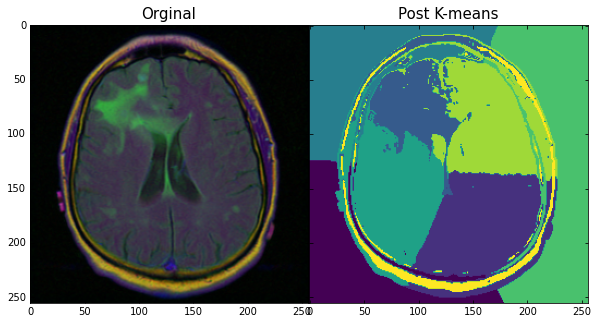

In [51]:
np.random.seed(0)

features = color_position_features(img)

# Sanity checks
assert features.shape == (H * W, C + 2),\
    "Incorrect shape! Check your implementation."

assert features.dtype == np.float,\
    "dtype of color_features should be float."

assignments = kmeans_fast(features, 8)
segments = assignments.reshape((H, W))

# Display segmentation
fig = plt.figure(figsize=(10., 10.))
grid = ImageGrid(fig, 111, nrows_ncols=(1, 2))
#MR Images
grid[0].imshow(img)
grid[0].set_title("Orginal", fontsize=15)
grid[0].axis("off")
grid[1].imshow(segments, cmap='viridis')
grid[1].set_title("Post K-means", fontsize=15)
grid[1].axis("off")